Перед вами таблица с результатами A/B-теста. В числовой колонке показаны значения выручки по каждому пользователю за период эксперимента.

Описание колонок
value – значения метрики
experimentVariant – Вариант теста (Control – контроль, Treatment – тест)
Задача
Нужно понять, стали ли мы больше зарабатывать с пользователя или нет. Вы уже знаете о существовании t-теста, U-теста Mann-Whitney и бутстрапа. Открытый вопрос: какой инструмент использовать?

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
from tqdm.auto import tqdm
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('C:/Users/Влад Чубенко/Downloads/hw_bootstrap.csv',sep=';', decimal = ',')

In [3]:
df.groupby('experimentVariant', as_index = False).agg({'value':'count'})

,experimentVariant,value
0,Control,500
1,Treatment,500


In [4]:
df.groupby('experimentVariant', as_index = False).agg({'value':'median'}) #медианы выборок приблизительно равны

,experimentVariant,value
0,Control,10.018465
1,Treatment,10.025847


In [5]:
df.groupby('experimentVariant', as_index = False).agg({'value':'mean'}) #средние сильно отличаются, посмотрим на распределения на графиках

,experimentVariant,value
0,Control,10.026867
1,Treatment,27.321499


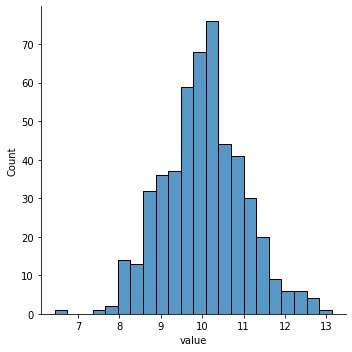

In [6]:
sns.displot(df[df.experimentVariant=='Control'].value) #распределение контрольной группы

<AxesSubplot:>

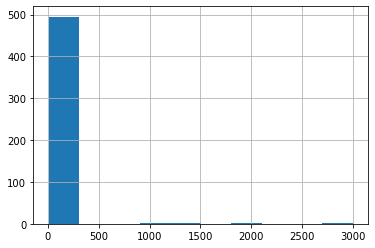

In [7]:
df[df.experimentVariant=='Treatment'].value.hist() #распределение тестовой группы, присутствуют выбросы

In [8]:
ttest_ind(df[df.experimentVariant =='Control'].value,
             df[df.experimentVariant=='Treatment'].value) #t-test

Ttest_indResult(statistic=-2.0729020485356604, pvalue=0.038437593613498765)

In [9]:
mannwhitneyu(df[df.experimentVariant =='Control'].value,
             df[df.experimentVariant=='Treatment'].value) #Манн_Уитни

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

In [10]:
def get_bootstrap_mean(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

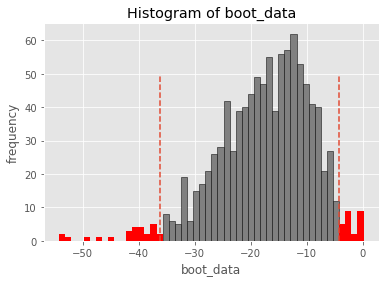

In [17]:
booted_data_mean = get_bootstrap_mean(df[df.experimentVariant =='Control'].value, df[df.experimentVariant=='Treatment'].value)

In [18]:
booted_data_mean['p_value'] #p-value для бутстрапа средних

0.03610425997309291

In [14]:
def get_bootstrap_median(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

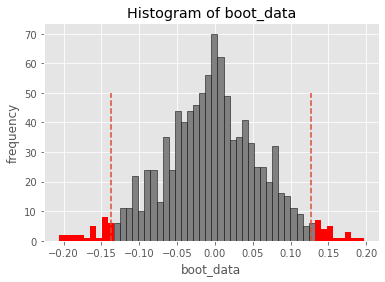

In [15]:
booted_data_median = get_bootstrap_median(df[df.experimentVariant =='Control'].value, df[df.experimentVariant=='Treatment'].value)

In [16]:
booted_data_median['p_value'] #p-value для бутстрапа медиан

0.9459458627291275

In [ ]:
#В выборке Treatment присутствуют явные выбросы, которые влияют на среднее. В связи с этим бутстрап средних и t-test нам не подходят. Поэтому стоит опираться на Манна-Уитни и бутстрап медиан. У них p-value>0.05, поэтому мы не можем опровергнуть гипотезу о равенстве средних, следовательно не можем утверждать, что стали зарабатывать больше. 

Тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение
Применяя бутстрап с оценкой среднего, мы могли бы отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия
Однако, тот же бутстрап, но уже по медиане не дает нам отклонить нулевую гипотезу, так как p-value сильно больше 0.05, т.к. здесь проверяется другая гипотеза
U-критерий Манна-Уитни так же не дал бы нам отклонить нулевую гипотезу. Оценки pvalue так же направлены как у бутстрапирования медианы